<a href="https://colab.research.google.com/github/anilbhatt1/Deep_Learning_EVA4_Phase1/blob/master/S10_Classwise_Accuracy_LRFinder_ReduceLR_On_Plateau.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
from datetime import datetime 
print("Current Date/Time: ", datetime.now())

Current Date/Time:  2020-04-04 12:01:49.861652


In [0]:
# Mounting the drive and copying the code from github to drive
from google.colab import drive 
drive.mount('/content/gdrive')
%cd gdrive/My Drive/project_folder
!git clone https://github.com/anilbhatt1/Deep_Learning_EVA4_Phase1
%cd Deep_Learning_EVA4_Phase1/S10_LRFinder_ReduceLRonPlateau
! ls

In [0]:
#!pip install torchviz
#%cd gdrive/My Drive/project_folder/Deep_Learning_EVA4_Phase1/S10_LRFinder_ReduceLRonPlateau
#! ls

In [3]:
from __future__ import print_function
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from tqdm import tqdm
#from torchviz import make_dot
from PIL import Image
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import cv2
from models import Alb_data_transforms,Model,Dataloaders,Train_Losses,Test_losses,Gradcam,lr_finder
import pkgutil
import importlib
%matplotlib inline

# install "apex" model for mixed precision training if required.. this is needed for LRFinder
if pkgutil.find_loader("apex") is None:
   print("****apex module does not exist..hence installing*****")
   !pip install -U git+https://www.github.com/NVIDIA/apex --no-cache-dir

import albumentations
print(albumentations.__version__) # check version

# This is to install and use albumentations latest package v0.4.5
album_version_needed = "0.4.5"
if albumentations.__version__ != album_version_needed:
  !pip install albumentations==0.4.5   # 0.4.5 is the latest albumentation version

print('Pytorch version:', torch.__version__)  

0.4.5
Pytorch version: 1.4.0


#### Below section of code is to get the mean and stdev of train data which will be used for normalization while applying transforms. **No need to execute this everytime** we run the file

In [16]:
train = torchvision.datasets.CIFAR10('./data', train=True, download=True)

n = 0
s = np.zeros(3)
sq = np.zeros(3)
i = 0
batchsize = 128
for data, l in tqdm_notebook(train):
  x = np.array(data)/255                             # Image Normalization 
  s += x.sum(axis=(0,1))                             # Summing up x & y values across 3 channels - CIFAR 10 size is 32,32,3. Useful for mean 
  sq += np.sum(np.square(x), axis=(0,1))             # Summing up x^2 and y^2 values across 3 channels. Useful for std dev calculation
  n += x.shape[0]*x.shape[1]                         # Summing up no: of pixels.Each channel has 32x32. Final pixels per channel = # images * 32 *32
  i += 1

batches = int(i/batchsize)
mu = s/n                               # mean = sum of pixel values/ no: of pixel values. Will return 3 element array as CIFAR10 has 3 channels
std = np.sqrt((sq/n - np.square(mu)))  # std dev = sqrt[sigma{x(i) - mean}^2/N]. Will return 3 element array as CIFAR10 has 3 channels
print('No: Of Train Images:', i, '\n'
      'No: Of Batches:', batches, '\n'
      'Channels Mean:',mu, '\n'
      'Channels Stdev:',std, '\n'
      'Channels squared sum mean:', sq/n, '\n'
      'Total Pixles (N):', n)

Files already downloaded and verified


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



No: Of Train Images: 50000 
No: Of Batches: 390 
Channels Mean: [0.49139968 0.48215841 0.44653091] 
Channels Stdev: [0.24703223 0.24348513 0.26158784] 
Channels squared sum mean: [0.30249857 0.29176174 0.26781806] 
Total Pixles (N): 51200000


#### Code section to **load** the train and test data and **applying transforms**

In [4]:
import albumentations as A

class_list = [0,1,2,3,4,5,6,7,8,9]
class_names_dict = {0:'plane', 1:'automob', 2:'bird', 3:'cat',4:'deer', 5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'}
class_names = ['plane', 'automobile', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck']

data_loader = Dataloaders.DataLoader(shuffle=True,batch_size=128,seed=1)

channels_mean  = (0.49139968, 0.48215841, 0.44653091)
channels_stdev = (0.24703223, 0.24348513, 0.26158784)
fillmeans = (np.array(channels_mean)*255).astype(np.uint8) # This is to fill additional space coming up while rotating image
              
test_transforms   = Alb_data_transforms.Albumentations_transform([A.Normalize(mean=channels_mean, std=channels_stdev)])
train_transforms  = Alb_data_transforms.Albumentations_transform([A.Rotate((-15.0, 15.0)),
                                                                  A.HorizontalFlip(),
                                                                  A.IAAAdditiveGaussianNoise(),
                                                                  A.RGBShift(r_shift_limit=50, g_shift_limit=50, b_shift_limit=50, p=0.5),
                                                                  A.Normalize(mean=channels_mean, std=channels_stdev),
                                                                  A.Cutout(num_holes=1,max_h_size=8,max_w_size=8), 
                                                                  # Using default fillvalue=0 for cutout because after normalizing mean is 0
                                                                  # Size used for cutout as 8 i.e. 25% of 32x32 CIFAR 10 data                                                                 
                                                                 ])

train_data = torchvision.datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test_data  = torchvision.datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

trainloader = data_loader.load(train_data)
testloader  = data_loader.load(test_data)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


#### Below function is to **unnormalize and bring back** the images to original pixel values. Function will be called while displaying images

In [0]:
channels_mean  = (0.49139968, 0.48215841, 0.44653091)
channels_stdev = (0.24703223, 0.24348513, 0.26158784)

# Function to unnormalize and bring back to original pixel values. Transpose is to reshape the image on x & y axes and make it ready for display

def unnormalize(img):
  #print('Unnorm')
  img = img.numpy().astype(dtype=np.float32)
  
  for i in range(img.shape[0]):
    img[i] = (img[i]*channels_stdev[i])+channels_mean[i]
  
  return np.transpose(img, (1,2,0))

#### Below section of code is to **display train images** from training set to get a high level idea on how our image dataset looks like with transforms



torch.Size([128, 3, 32, 32])
torch.Size([128])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

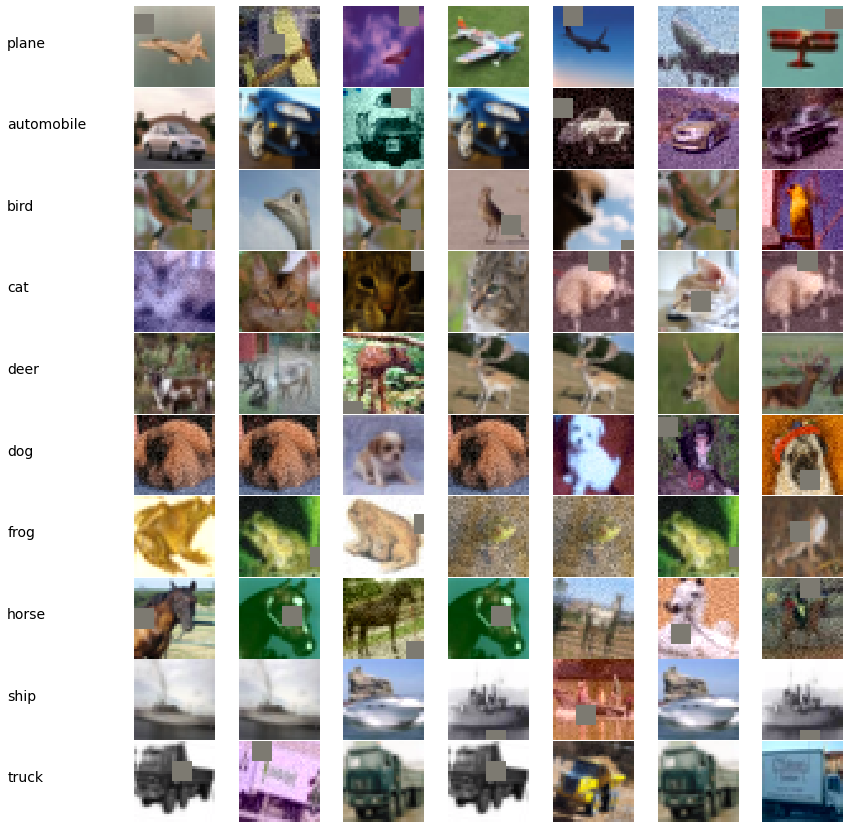

In [6]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

num_classes = 10
# display 7 images from each category. 
class_names = ['plane', 'automobile', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck']

row, col = 10, 8
num_images = 7
fig = plt.figure(figsize=(15,15))
fig.subplots_adjust(hspace=0.01, wspace=0.01)
for class_num in range(num_classes):
    idx = np.random.choice(np.where(labels[:]==class_num)[0], num_images)  ## Selecting 7 random images for each class
    ax = plt.subplot(row, col,class_num*col+1)                             ## Laying out space for display of a particular class
    ax.text(-0.1, 0.5, class_names[class_num], fontsize=14)                ## Displaying class names
    plt.axis('off')
    for j in range(1, num_images+1):                                       ## Displaying images one-by-one for a particular class
      plt.subplot(row, col, class_num*col+j+1)
      plt.imshow(unnormalize(images[idx[j-1]]), interpolation='none')
      plt.axis('off')
plt.show()

In [7]:
!pip install torchsummary
from torchsummary import summary
model = Model.ResNet18()
use_cuda = torch.cuda.is_available()
model.device = torch.device("cuda" if use_cuda else "cpu")
model.to(model.device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

In [0]:
train_loss = Train_Losses.Train_loss()
test_loss  = Test_losses.Test_loss()

#### Function to calculate **class-wise Test Accuracy**

In [0]:
class_list = [0,1,2,3,4,5,6,7,8,9]

def calc_classwiseacc(total_cnt,correct_cnt):
    class_test_acc = []
    epsilon    = 1e-10                     # To avoid division by zero incase not a single image showed up for a particular class
    for i in range(len(class_list)):
        correct_class   =  total_class = 0
        correct_class   =  correct_cnt.get(class_list[i])
        total_class     =  total_cnt.get(class_list[i])
        total_class     += epsilon
        class_accuracy  =  round((correct_class/total_class *100), 2)
        class_test_acc.append(class_accuracy)
        print ('Test accuracy for class - ', class_list[i], ' - ', class_names_dict.get(class_list[i]), ' : ', class_accuracy, \
               'correct:',correct_class, 'Total:',int(total_class) )
    
    print('Total Test Images:',sum(total_cnt.values()),'Correct Images:',sum(correct_cnt.values()) )

    return class_test_acc   

#### Print the **Layer/module names*** of model

In [0]:
for name, module in model.named_modules():
    print('name:',name)

#### **LR Finder**
How LR Finder Range_Test works:
Range Test is to find out the best starting LR for our model training. It is an easy method to find out an LR which we can start with. During model training, we will start with this LR and then increase/decrease LR based on cyclic LR ( isosceles trinagle with an extension at second half) or OneCycle LR policy which is deployed for model training.

**lrfinder.range_test(trainloader, start_lr=1e-3, end_lr=20, num_iter=200, step_mode="linear")**

Here **'start_lr' will get calculated** based on 'end_lr' and 'num_iter'. Eventhough, we gave 0.001 as 'start_lr' above, algorithm may not start at that LR. Algorithm will reverse engineer and find out which 'start_lr' it should choose to reach 'end_lr' (20 above) in number of iterations provided (200 above). This reverse engineering calculation also depends on step_mode we are giving i.e. 'linear' or 'exponential'. 'Step_mode' tells how we need to increase our LR after each iteration - linearly or exponentially.

Also we need to **choose 'num_iter'** carefully as per start_lr and end_lr values given. A jump from start_lr of 0.001 to end_lr 100 that too exponentially in just 100 iterations will lead to missing out on lot of useful intermediate LR values. In such cases, we may get the following message **"Stopping early, the loss has diverged"** very early even before completing the 100 iterations. To get a meaningful LR value from range test, in this scenario 500-700 iterations may help. This way algorithm gets chance to test at finer intermediate values as **num_iter** is high enough. 

In [0]:
import torch.optim as optim

L2_factor = 0.0001
L1_factor = 0.0005
OPTIMIZER = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=L2_factor)
#SCHEDULER = OneCycleLR(OPTIMIZER, max_lr=0.2, steps_per_epoch=len(trainloader), epochs=EPOCH)
criterion = nn.CrossEntropyLoss()
lrfinder = lr_finder.LRFinder(model=model, optimizer=OPTIMIZER, criterion=criterion, device=model.device)

In [11]:
# *** The learning rate range test increases the learning rate in a pre-training run between two boundaries in a linear or exponential manner.
# start_lr (float, optional): the starting learning rate for the range test. Default: None (uses the learning rate from the optimizer).
# end_lr (float, optional): the maximum learning rate to test. Default: 10.
# num_iter (int, optional): the number of iterations over which the test occurs. Default: 100.
# step_mode (str, optional): one of the available learning rate policies, linear or exponential ("linear", "exp"). Default: "exp".

lrfinder.range_test(trainloader, start_lr=1e-7, end_lr=20, num_iter=700, step_mode="linear")

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


Total Observations:  308
Starting Loss:  4.04839622845821 Ending Loss:  5.939329822430369
Starting Lr:  0.34285724114285715 Ending Lr:  9.114285768714286
#  1  - Least Loss :  2.2040898713727115 Its corresponding LR:  4.057142936857143
#  2  - Least Loss :  2.2055182016774904 Its corresponding LR:  6.114285783714286
#  3  - Least Loss :  2.208113272659077 Its corresponding LR:  6.085714355285714


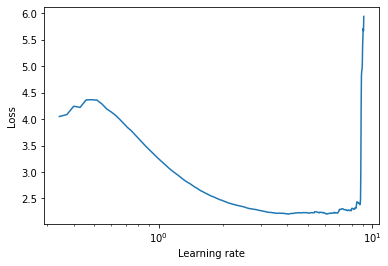

In [13]:
# Training Loss Vs LR
lrfinder.plot()

In [16]:
# To restore the model and optimizer to their initial state
lrfinder.reset()

'''
Here model is evaluated on the test dataset after each iteration.
The test loss is more sensitive to instability therefore it provides a more precise view of when the divergence occurs. 
The disadvantage is that it takes significantly longer to run
'''
lrfinder.range_test(trainloader, val_loader=testloader, start_lr=1e-7, end_lr=20, num_iter=500, step_mode="exp")

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


Total Observations:  345
Starting Loss:  2.303760886742755 Ending Loss:  5.85014402008783
Starting Lr:  1.5820664467287618e-07 Ending Lr:  0.08134546702864581
#  1  - Least Loss :  1.8975459943161572 Its corresponding LR:  0.0048059684733897275
#  2  - Least Loss :  1.9024520795381035 Its corresponding LR:  0.004625714851927473
#  3  - Least Loss :  1.9042811388294751 Its corresponding LR:  0.00499324616985236


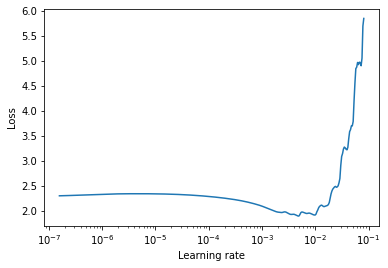

In [17]:
lrfinder.plot()

Finding **starting LR** to start training based on LR Range Test results with val_loader=testloader. This LR will be used inside Optimizer for training.

In [18]:
lrfinder_loss_copy = lrfinder.history['loss']
lrfinder_lr_copy   = lrfinder.history['lr']
least_loss_lr = lrfinder_lr_copy[lrfinder_loss_copy.index(min(lrfinder_loss_copy))]
least_loss_lr 

0.0048059684733897275

# Train and Test the model using ReduceLROnPlateau

**ReduceLROnPlateau-**Reduce learning rate when a metric has stopped improving. Models often benefit from reducing the learning rate by a factor of 2-10 once learning stagnates. This scheduler reads a metrics quantity and if no improvement is seen for a ‘patience’ number of epochs, the learning rate is reduced by 'factor' supplied. 

mode = 'min' means lr will be reduced when the quantity monitored has stopped decreasing; in 'max' mode it will be reduced when the quantity monitored has stopped increasing.

'min_lr' -> A lower bound on the LR upto which it can be reduced

In [0]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import OneCycleLR

EPOCH     = 3

train_loss_all = []
train_acc_all  = []
test_loss_all  = []
test_acc_all   = []
classwise_acc  = []
class_acc_all  = []

OPTIMIZER = optim.SGD(model.parameters(), lr=least_loss_lr, momentum=0.9, weight_decay=L2_factor)
SCHEDULER = ReduceLROnPlateau(OPTIMIZER, mode = 'min', factor = 0.1, min_lr=1e-7, patience = 4, verbose=True)

for epoch in range(EPOCH):

    print("\nEPOCH:", epoch)
    train_losses, train_acc = train_loss.train_loss_calc(model,model.device,train_loader=trainloader,optimizer=OPTIMIZER,
                                                         epoch=EPOCH,factor=L1_factor,criterion=criterion,scheduler=SCHEDULER,print_idx=0,maxlr=0.2)
    test_losses, test_acc, wrong_predict, predicted_class, actual_class, label_total, label_correct = \
                              test_loss.test_loss_calc(model,model.device,test_loader=testloader, optimizer=OPTIMIZER, total_epoch=EPOCH, 
                                                       current_epoch = epoch,criterion=criterion,scheduler=SCHEDULER)

    if epoch == (EPOCH -1):
      classwise_acc = calc_classwiseacc(label_total,label_correct)
      class_acc_all.append(classwise_acc)                          
        
    train_loss_all.extend(train_losses)
    train_acc_all.extend(train_acc)
    test_loss_all.extend(test_losses)
    test_acc_all.extend(test_acc)

    if len(test_loss_all) > 1:
       loss_decrease = 0                  
       loss_decrease = test_loss_all[-2] - test_loss_all[-1]                             
       if loss_decrease > 0:
          print('Test Loss -> Decreasing, Prev Loss: {:.6f}, Latest Loss: {:.6f}, Delta: {:.6f}' .format(test_loss_all[-2], test_loss_all[-1], loss_decrease))     
       else: 
          print('Test Loss -> Increasing, Prev Loss: {:.6f}, Latest Loss: {:.6f}, Delta: {:.6f}' .format(test_loss_all[-2], test_loss_all[-1], loss_decrease))  

  0%|          | 0/391 [00:00<?, ?it/s]


EPOCH: 0
ERROR! Session/line number was not unique in database. History logging moved to new session 69


Train Loss = 0.6843637228012085 Batch Id = 390 Train Acc = 77.96 LR =0.0048059684733897275: 100%|██████████| 391/391 [00:50<00:00,  7.73it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0051, Test Accuracy: 78.05, LR : 0.004806


EPOCH: 1


Train Loss = 0.43171513080596924 Batch Id = 164 Train Acc = 79.55 LR =0.0048059684733897275:  42%|████▏     | 164/391 [00:21<00:30,  7.41it/s]

In [0]:
####Next few cells are for testing only. Will be deleted later

In [0]:
'''
########### Train Loss

from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from tqdm import tqdm

# # class for Calculating and storing training losses and training accuracies of model for each batch per epoch ## 
class Train_loss:
        
      def train_loss_calc(self,model, device, train_loader, optimizer, epoch, factor, criterion, scheduler =None, print_idx=0, maxlr=0):
            
          self.model        = model
          self.device       = device
          self.train_loader = train_loader
          self.optimizer    = optimizer   
          self.epoch        = epoch
          self.factor       = factor
          self.criterion    = criterion      
          self.scheduler    = scheduler
          self.print_idx    = print_idx
          self.maxlr        = maxlr    
          #self.metric       = 0      
          
          model.train()
          pbar = tqdm(train_loader)  # Wrapping train_loader in tqdm to show progress bar for each epoch while training          
            
          correct             = 0
          total               = 0
          train_losses        = []
          train_acc           = []
          
          for batch_idx, data in enumerate(pbar,0):
                        
              images, labels = data        
                       
              images, labels = images.to(device), labels.to(device)   # Moving images and correspondig labels to GPU
              optimizer.zero_grad()  # Zeroing out gradients at start of each batch so that backpropagation won't take accumulated value
              labels_pred = model(images)  # Calling CNN model to predict the images
              loss = criterion(labels_pred, labels)   # Calculating Negative Likelihood Loss by comparing prediction vs ground truth
              
              # Applying L1 regularization to the training loss calculated
              L1_criterion = nn.L1Loss(size_average = None, reduce = None, reduction = 'mean')
              reg_loss     = 0
              for param in model.parameters():
                zero_tensor = torch.rand_like(param) * 0 # Creating a zero tensor with same size as param
                reg_loss    += L1_criterion(param, zero_tensor)
              loss += factor * reg_loss 
              
            
              # Backpropagation
              loss.backward()
              optimizer.step()
              
              # This was used for OneCycle LR policy. 'get_last_lr()' giving error while using ReduceLRonPlateau hence commenting out 
              #lr = self.scheduler.get_last_lr()[0] if self.scheduler else (self.optimizer.lr_scheduler.get_last_lr()[0] if self.optimizer.lr_scheduler else self.optimizer.param_groups[0]['lr'])
              
              lr = 0
              #print('self.scheduler:', self.scheduler,'scheduler:', scheduler)
              #print(isinstance(self.scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau))                 
              #print('batch_idx:', batch_idx)
              #print('self.optimizer:',self.optimizer,'optimizer:',optimizer)
              #print('self.optimizer.lr_policy:', self.optimizer.lr_policy)   
              #print('self.optimizer.param_groups[0][lr]:', self.optimizer.param_groups[0]['lr'])
        
              #if scheduler:   # this is for batchwise lr update
              #   print('Entering steps:',scheduler)   
              #   scheduler.step(self.metric) 
              #print('lr - scheduler.get_last_lr()[0]:', scheduler.get_last_lr()[0])        
        
              if scheduler and not (isinstance(self.scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau)):
                 lr = self.scheduler.get_last_lr()[0]
              else:
                 lr = self.optimizer.param_groups[0]['lr']                
                
              #if self.scheduler:   # this is for batchwise lr update
              #   self.scheduler.step(batch_idx)    
                        
              # Calculating accuracies
              labels_pred_max = labels_pred.argmax(dim = 1, keepdim = True) # Getting the index of max log probablity predicted by model
              correct         += labels_pred_max.eq(labels.view_as(labels_pred_max)).sum().item() # Getting count of correctly predicted
              total           += len(images) # Getting count of processed images
              train_acc_batch = (correct/total)*100            
              pbar.set_description(desc=f'Train Loss = {loss.item} Batch Id = {batch_idx} Train Accuracy = {train_acc_batch:0.2f} LR = {lr}')                                   
                                        
              #if self.scheduler:   # this is for batchwise lr update
              #   self.scheduler.step(lr) 
              #   print('final lr:',lr)

          train_acc.append(train_acc_batch)  # To capture only final batch accuracy of an epoch
          train_losses.append(loss)          # To capture only final batch loss of an epoch
        
          return train_losses, train_acc    
'''               

In [0]:
'''
#############TEST LOSS

from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau

# # class for Calculating and storing testing losses and testing accuracies of model for each epoch ## 
class Test_loss:

       def test_loss_calc(self,model, device, test_loader, optimizer, total_epoch, current_epoch, criterion, scheduler):
           self.model        = model
           self.device       = device
           self.test_loader  = test_loader
           self.optimizer    = optimizer
           self.total_epoch  = total_epoch
           self.current_epoch= current_epoch
           self.criterion    = criterion
           self.scheduler    = scheduler
       
           model.eval()
           
           correct        = 0 
           total          = 0              
           test_loss      = 0
           test_accuracy  = 0 
           test_losses    = []
           test_acc       = []
           predicted_class= []
           actual_class   = []
           wrong_predict  = []
           count_wrong    = 0 
           
           label_dict     = {0:0, 1:1, 2:2, 3:3, 4:4, 5:5, 6:6, 7:7, 8:8, 9:9}
           label_total    = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0}
           label_correct  = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0}   
                       
           with torch.no_grad():                     # For test data, we won't do backprop, hence no need to capture gradients
                for images,labels in test_loader:    # We are working in GPU, so 1 iteration will process 128 images(batch_size) in a go. Total 10,000/128 = 79 iterations will happen
 
                    images,labels    = images.to(device),labels.to(device)                                      # Images -> Tensor with shape torch.Size([128, 3, 32, 32])
                    labels_pred      = model(images)                                                            # labels_pred -> Tensor with shape torch.Size([128, 10]) 
                    #test_loss       += criterion(labels_pred, labels, reduction = 'sum').item()                # Use torch.Tensor.item() to get a Python number from a tensor containing a single value              
                    test_loss        += criterion(labels_pred, labels).item()                                   # Use torch.Tensor.item() to get a Python number from a tensor containing a single value                
                    labels_pred_max  = labels_pred.argmax(dim =1, keepdim = True)                               # labels_pred_max -> Tensor with shape torch.Size([128, 1]). We are taking maximum value out of 10 from 'labels_pred' tensor
                    correct          += labels_pred_max.eq(labels.view_as(labels_pred_max)).sum().item()        # labels -> Tensor with shape torch.Size([128]). We are changing shape of labels to ([128, 1]) for comparison purpose
                    total            += labels.size(0)                                                          # Taking number of labels in each batch size and accumulating it to get total images at end. Here labels.size(0)  = 128
                    ''' 
                    ''' labels_pred_max will look like below: torch.Size([128, 1])
                     ([[3],
                       [0],
                       [5],
                       .
                       .
                       [7]], device='cuda:0') -> 128th element
                       
                       labels will look like below: torch.Size([128])
                       ([3, 2, 5, 5, 0, 9,.....4, 4], device='cuda:0') 
                       
                       labels_pred will look like below: torch.Size([128, 10])
                       tensor([[-1.3098e+00, -5.1958e+00, -4.3112e+00,  ..., -6.5936e+00,
                                -4.1666e-01, -4.0672e+00], -> 10 elements in each row
                               [-7.6204e+00, -9.2902e+00, -4.8976e+00,  ..., -1.4079e-01,
                                -9.6599e+00, -8.5457e+00],
                                .
                                .
                               [-2.2386e+00, -3.1282e+00, -4.0142e+00,  ..., -2.4335e+00,
                                -4.5057e+00, -1.2379e+00]], device='cuda:0') -> 128th row
                      
                      * labels_pred_max.item() -> This will fail because torch.Tensor.item() is to get a Python number from a tensor containing a single value   
                      * labels.item() ->  This will fail because torch.Tensor.item() is to get a Python number from a tensor containing a single value
                      * labels_pred.item() ->  This will fail because torch.Tensor.item() is to get a Python number from a tensor containing a single value
                      * labels.view_as(labels_pred_max).item() -> This will fail because torch.Tensor.item() is to get a Python number from a tensor containing a single value
                      * if labels_pred_max == labels:  -> This will fail beacuse we are comparing different shapes                                        
                      * len(labels_pred_max) = 128 which is same as batch_size
                      * if labels_pred_max[i] == labels[i]: -> This will work because we are gathering specific elements and comparing
                      * if labels_pred_max[2] == labels[2]: -> This will work because we are gathering specific elements and comparing
                      * labels_pred_max[i] -> Will look like tensor([5], device='cuda:0') 
                      * labels[i] -> Will look like tensor(2, device='cuda:0')
                      * labels[i].item() -> Will work & return an integer
                      * labels_pred_max[i].item() -> Will work & return an integer
                    '''
                    '''
                    if current_epoch == (total_epoch - 1): 
                           for i in range(len(labels_pred_max)):
                               counter_key = ' '
                               counter_key = label_dict.get(labels[i].item())   # Getting labels from 'label_dict'
                               label_total[counter_key] += 1                    # Increasing total count of corresponding label

                               if labels_pred_max[i] == labels[i]:
                                  label_correct[counter_key] += 1               # Increasing correct count of corresponding label
                               else:    
                                  if count_wrong   < 26:                                            # Capturing 26 wrongly predicted images for last epoch
                                     wrong_predict.append(images[i])                                # with its predicted and actual class 
                                     predicted_class.append(labels_pred_max[i].item())
                                     actual_class.append(labels[i].item())
                                     count_wrong += 1
              
                test_loss   /= total  # Calculating overall test loss for the epoch
                test_losses.append(test_loss)    
                                  
                test_accuracy =  (correct/total)* 100
                test_acc.append(test_accuracy)                       
            
                lr = 0              
                if scheduler and not isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                   lr = self.scheduler.get_last_lr()[0]
                else:
                   lr = self.optimizer.param_groups[0]['lr']
                #print('lr before scheduler.step():',lr)                                
                
                scheduler.step(test_loss)
                lr = self.optimizer.param_groups[0]['lr']
                #print('lr after scheduler.step():',lr)    
               
                print('\nTest set: Average loss: {:.4f}, Test Accuracy: {:.2f}, Learning Rate: {:.6f}\n' .format(test_loss, test_accuracy,lr))

           return test_losses, test_acc, wrong_predict, predicted_class, actual_class, label_total, label_correct

In [0]:
'''
train_loss = Train_loss()
test_loss  = Test_loss()
least_loss_lr = 0.008
'''

In [0]:
'''
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import OneCycleLR

EPOCH     = 3

train_loss_all = []
train_acc_all  = []
test_loss_all  = []
test_acc_all   = []
classwise_acc  = []
class_acc_all  = []

OPTIMIZER = optim.SGD(model.parameters(), lr=least_loss_lr, momentum=0.9, weight_decay=L2_factor)
SCHEDULER = ReduceLROnPlateau(OPTIMIZER, mode = 'min', factor = 0.1, min_lr=1e-7, patience = 4, verbose=True)

for epoch in range(EPOCH):

    print("\nEPOCH:", epoch)
    train_losses, train_acc = train_loss.train_loss_calc(model,model.device,train_loader=trainloader,optimizer=OPTIMIZER,
                                                         epoch=EPOCH,factor=L1_factor,criterion=criterion,scheduler=SCHEDULER,print_idx=0,maxlr=0.2)
    test_losses, test_acc, wrong_predict, predicted_class, actual_class, label_total, label_correct = \
                              test_loss.test_loss_calc(model,model.device,test_loader=testloader, optimizer=OPTIMIZER, total_epoch=EPOCH, 
                                                       current_epoch = epoch,criterion=criterion,scheduler=SCHEDULER)

    if epoch == (EPOCH -1):
      classwise_acc = calc_classwiseacc(label_total,label_correct)
      class_acc_all.append(classwise_acc)                          
        
    train_loss_all.extend(train_losses)
    train_acc_all.extend(train_acc)
    test_loss_all.extend(test_losses)
    test_acc_all.extend(test_acc)

    if len(test_loss_all) > 1:
       loss_decrease = 0                  
       loss_decrease = test_loss_all[-2] - test_loss_all[-1]                             
       if loss_decrease > 0:
          print('Test Loss -> Decreasing')     
       else: 
          print('Test Loss -> Increasing') 
       print('Prev Loss: {:.6f}, Latest Loss: {:.6f}, Delta: {:.6f}' .format(test_loss_all[-2], test_loss_all[-1], loss_decrease))  
'''           

#### Below section of code is to plot **misclassified images** received from last epoch

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


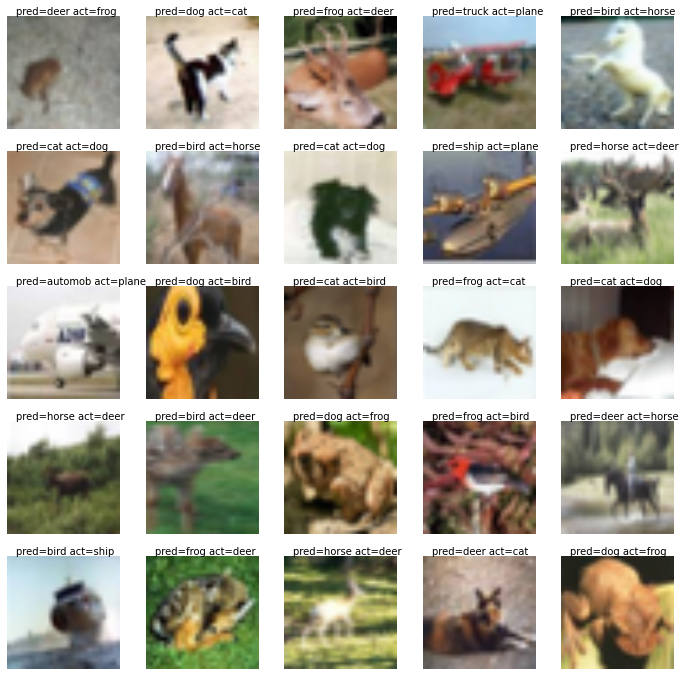

In [0]:
# Plotting misclassified images received from last epoch. Will throw error message if misclassified images <25. 
# In case of such an event adjust the subplots to suit the number of images to be plotted

figure=plt.figure(figsize=(12,12))
if len(predicted_class) > 25: 
    for i in range(25):
      plt.subplot(5,5,i+1)
      plt.axis(False)
      #plt.imshow(unnormalize(wrong_predict[i].cpu()), interpolation='none')
      plt.imshow(unnormalize(wrong_predict[i].cpu()),interpolation='bilinear')
      prediction = class_names_dict.get(predicted_class[i])
      actual     = class_names_dict.get(actual_class[i])
      s="pred="+str(prediction)+" act="+str(actual)
      #s="predicted="+str(predicted_class[i])+" actual="+str(actual_class[i])
      plt.text(2,-1,s)
else:
  print('Less than 25 images:', len(predicted_class))

#### Below section of code is to plot **validation accuracy, test loss, training accuracy and train loss** for the all the epochs trained

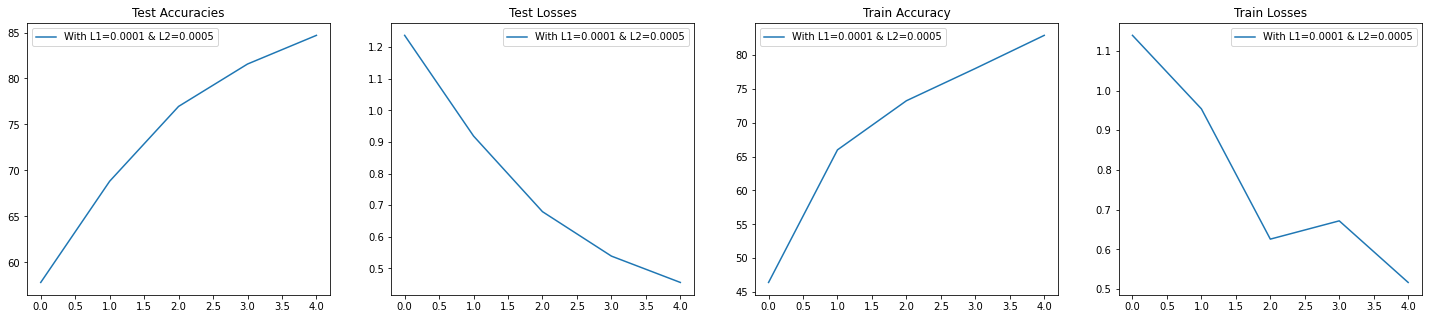

In [0]:
figure = plt.figure(figsize=(25,5))
labels = ['With L1=0.0001 & L2=0.0005']

plt.subplot(1,4,1)
plt.title("Test Accuracies")
plt.plot(test_acc_all,label=labels[0])
plt.legend(loc="best")

plt.subplot(1,4,2)
plt.title("Test Losses")
plt.plot(test_loss_all,label=labels[0])
plt.legend(loc="best")

plt.subplot(1,4,3)
plt.title("Train Accuracy")
plt.plot(train_acc_all,label=labels[0])
plt.legend(loc="best")   

plt.subplot(1,4,4)
plt.title("Train Losses")
plt.plot(train_loss_all,label=labels[0])
plt.legend(loc="best")    

In [0]:
figure = plt.figure(figsize=(20,20))
i = j = 0
for i in range(len(class_list)):
    class_num = class_list[i]
    lst = []
    class_num_accuracy = []
    for j in range(len(class_acc_all)):
        class_num_accuracy.append(class_acc_all[j][class_num])
    plt.subplot(5,5,int(class_num+1))
    title_str = 'Test Accuracy for Class-'+ str(class_num) + '-' + str(class_names_dict.get(class_num))
    plt.title(title_str)
    label_str = str(class_num) + '-' + str(class_names_dict.get(class_num))
    plt.plot(class_num_accuracy,label=label_str)
    plt.legend(loc="best")       

##Gradcam



In [0]:
'''
Below code section shows how to receive & prepare external images for Gradcam

# This will upload the zip file to colab. A prompt will appear to choose files
from google.colab import files
uploaded = files.upload()
# To import zipfile
import zipfile
from zipfile import ZipFile 
file_name = "S9_GradCam_Images.zip"
with ZipFile(file_name, 'r') as zip: 
     zip.printdir()
     zip.extractall() 
# To list the files in directory
import os
for img in os.listdir('S9_GradCam_Images/'):  
    img_name = os.path.join('S9_GradCam_Images/',img)  # convert to array
    print(img_name)     
# Preparing image for GradCAM
gradcam_images = [(0, 'S9_GradCam_Images/Plane_2.jpg'),
                  (1, 'S9_GradCam_Images/Car_2.jpg'),
                  (2, 'S9_GradCam_Images/Bird_2.jpg'),
                  (3, 'S9_GradCam_Images/Cat_2.jpg'),
                  (4, 'S9_GradCam_Images/Deer_1.jpg'),
                  (5, 'S9_GradCam_Images/Dog_2.jpg'),
                  (6, 'S9_GradCam_Images/Frog_1.jpg'),
                  (7, 'S9_GradCam_Images/Horse_2.jpg'),
                  (8, 'S9_GradCam_Images/Ship_2.jpg'),
                  (9, 'S9_GradCam_Images/Truck_1.jpg')]

images = []
target_classes = []

j = 0
for i in gradcam_images:
  if j == 0:
    images.append(getimage(i[1], test_transforms))
    target_classes.append(i[0])  

def getimage(img, transform,input_size=(32,32)):
    img = cv2.imread(img, 1)
    img = img[:,:, -1::-1]
    img = np.uint8(cv2.resize(img, input_size))
    img = transform(img)
    img = np.transpose(img, (0,1,2))
    return img
'''      

In [0]:
#target_layers = ["layer4"]
#gradcam_output, probs, predicted_classes = Gradcam.GRADCAM(images, target_classes, model, target_layers)
#Gradcam.PLOT(gradcam_output, images, target_classes, target_layers, class_names, (3, 32, 32), predicted_classes, unnormalize)

In [0]:
img_all = img_1 = img_2 = img_3 = []
target_all = target_1 = target_2 = target_3 = []
test1_transforms   = Alb_data_transforms.Albumentations_transform([])
target_layers = ["layer4"]
#Grad_CAM1(model,target_layers)

for i in range(len(wrong_predict)):
     img = wrong_predict[i].cpu().numpy()
     img = np.transpose(img, (1,2,0))
     img = test1_transforms(img)
     img_all.append(img)
     target_all.append(actual_class[i])

img_1 = img_all[0:10]
img_2 = img_all[10:20]
img_3 = img_all[20:25]
target_1 = target_all[0:10]
target_2 = target_all[10:20]
target_3 = target_all[20:25]

torch.Size([10, 10])
Generating Grad-CAM @layer4


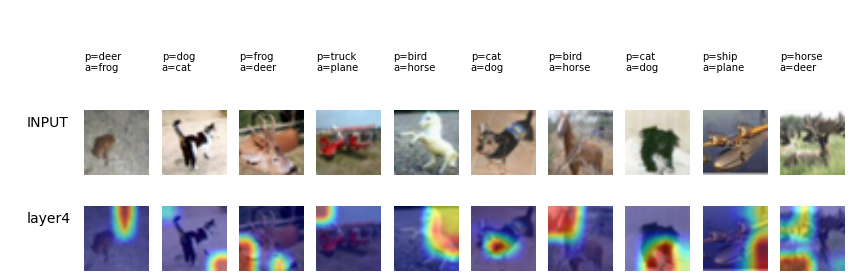

torch.Size([10, 10])
Generating Grad-CAM @layer4


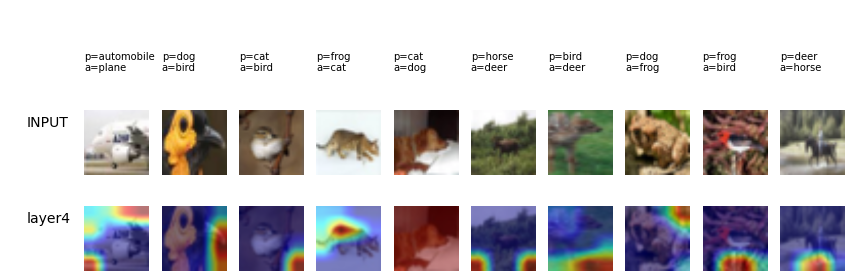

torch.Size([5, 10])
Generating Grad-CAM @layer4


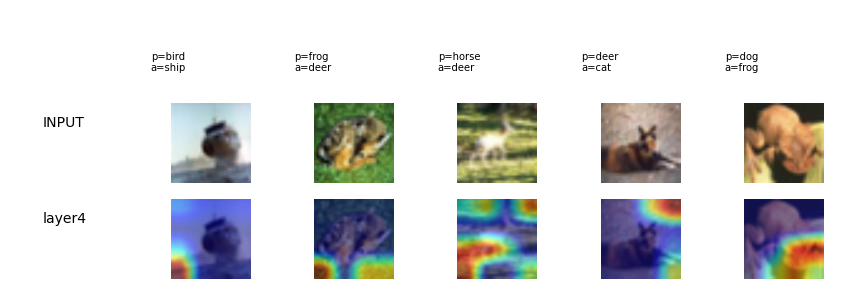

In [0]:
images = []
target_classes = [] 
grad_cam_list = [1,2,3]
for i in range(len(grad_cam_list)):
    if i == 0:
      images = img_1
      target_classes = target_1
    elif i == 1:
      images = img_2
      target_classes = target_2
    elif i == 2:
      images = img_3
      target_classes = target_3    
    gradcam_output, probs, predicted_classes = Gradcam.GRADCAM(images, target_classes, model, target_layers)
    Gradcam.PLOT(gradcam_output, images, target_classes, target_layers, class_names, (3, 32, 32), predicted_classes, unnormalize)
    images = []
    target_classes = []     

In [0]:
'''
images = []
target_classes = [] 
grad_cam_list = [1,2,3]
for i in range(len(grad_cam_list)):
    if i == 0:
      images = img_1
      target_classes = target_1
    elif i == 1:
      images = img_2
      target_classes = target_2
    elif i == 2:
      images = img_3
      target_classes = target_3    
    gradcam_output, probs, predicted_classes = GRAD_CAM1(images, target_classes, model, target_layers)
    Gradcam_PLOT(gradcam_output, images, target_classes, target_layers, class_names, (3, 32, 32), predicted_classes, unnormalize)
    images = []
    target_classes = []     
'''    

'\nimages = []\ntarget_classes = [] \ngrad_cam_list = [1,2,3]\nfor i in range(len(grad_cam_list)):\n    if i == 0:\n      images = img_1\n      target_classes = target_1\n    elif i == 1:\n      images = img_2\n      target_classes = target_2\n    elif i == 2:\n      images = img_3\n      target_classes = target_3    \n    gradcam_output, probs, predicted_classes = GRAD_CAM1(images, target_classes, model, target_layers)\n    Gradcam_PLOT(gradcam_output, images, target_classes, target_layers, class_names, (3, 32, 32), predicted_classes, unnormalize)\n    images = []\n    target_classes = []     \n'

In [0]:
'''
class Grad_CAM1:
    """ Class for extracting activations and 
    registering gradients from targetted intermediate layers 
    target_layers = list of convolution layer index as shown in summary
    """
    def __init__(self, model, candidate_layers=None):
        def save_fmaps(key):
          def forward_hook(module, input, output):
              #print('forward_hook1')
              self.fmap_pool[key] = output.detach()

          return forward_hook

        def save_grads(key):
          def backward_hook(module, grad_in, grad_out):
              #print('backward_hook1')
              self.grad_pool[key] = grad_out[0].detach()

          return backward_hook

        self.device = next(model.parameters()).device
        self.model = model
        self.handlers = []  # a set of hook function handlers
        self.fmap_pool = {}
        self.grad_pool = {}
        self.candidate_layers = candidate_layers  # list

        for name, module in self.model.named_modules():
            if self.candidate_layers is None or name in self.candidate_layers:
                self.handlers.append(module.register_forward_hook(save_fmaps(name)))
                self.handlers.append(module.register_backward_hook(save_grads(name)))

    def _encode_one_hot(self, ids):
        one_hot = torch.zeros_like(self.nll).to(self.device)
        print(one_hot.shape)
        one_hot.scatter_(1, ids, 1.0)
        return one_hot

    def forward(self, image):
        self.image_shape = image.shape[2:] # HxW
        self.nll = self.model(image)
        #self.probs = F.softmax(self.logits, dim=1)
        return self.nll.sort(dim=1, descending=True)  # ordered results

    def backward(self, ids):
        """
        Class-specific backpropagation
        """
        one_hot = self._encode_one_hot(ids)
        self.model.zero_grad()
        self.nll.backward(gradient=one_hot, retain_graph=True)

    def remove_hook(self):
        """
        Remove all the forward/backward hook functions
        """
        for handle in self.handlers:
            handle.remove()

    def _find(self, pool, target_layer):
        if target_layer in pool.keys():
            return pool[target_layer]
        else:
            raise ValueError("Invalid layer name: {}".format(target_layer))

    def generate(self, target_layer):
        fmaps = self._find(self.fmap_pool, target_layer)
        grads = self._find(self.grad_pool, target_layer)
        weights = F.adaptive_avg_pool2d(grads, 1)

        gcam = torch.mul(fmaps, weights).sum(dim=1, keepdim=True)
        gcam = F.relu(gcam)
        # need to capture image size duign forward pass
        gcam = F.interpolate(
            gcam, self.image_shape, mode="bilinear", align_corners=False
        )

        # scale output between 0,1
        B, C, H, W = gcam.shape
        gcam = gcam.view(B, -1)
        gcam -= gcam.min(dim=1, keepdim=True)[0]
        gcam /= gcam.max(dim=1, keepdim=True)[0]
        gcam = gcam.view(B, C, H, W)

        return gcam

def GRAD_CAM1(images, labels, model, target_layers):
  model.eval()
  # map input to device
  images = torch.stack(images).to(model.device)
  # set up grad cam
  gcam = Grad_CAM1(model, target_layers)
  # forward pass
  probs, ids = gcam.forward(images)
  # outputs agaist which to compute gradients
  ids_ = torch.LongTensor(labels).view(len(images),-1).to(model.device)
  # backward pass
  gcam.backward(ids=ids_)
  layers = []
  for i in range(len(target_layers)):
    target_layer = target_layers[i]
    print("Generating Grad-CAM @{}".format(target_layer))
    # Grad-CAM
    layers.append(gcam.generate(target_layer=target_layer))
  # remove hooks when done
  gcam.remove_hook()
  return layers, probs, ids

def Gradcam_PLOT(gcam_layers, images, labels, target_layers, class_names, image_size, predicted, unnormalize):
    c = len(images)+1
    #print('c:',c)
    r = len(target_layers)+2
    #print('r:',r)
    fig = plt.figure(figsize=(15,5))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
    ax = plt.subplot(r, c, 1)
    ax.text(0.3,-0.5, "INPUT", fontsize=14)
    plt.axis('off')
    #print('len(target_layers):',len(target_layers))
    for i in range(len(target_layers)):
      #print('i:',i)
      target_layer = target_layers[i]
      #print('target_layers[i]:',target_layers[i])
      ax = plt.subplot(r, c, c*(i+1)+1)
      #print('r, c, c*(i+1)+1:',r, c, c*(i+1)+1)
      ax.text(0.3,-0.5, target_layer, fontsize=14)
      plt.axis('off')

      for j in range(len(images)):
        #print('j:',j)
        img = np.uint8(255*unnormalize(images[j].view(image_size)))
        #img = np.uint8(unnormalize(images[j].view(image_size)))
        if i==0:
          ax = plt.subplot(r, c, j+2)
          #print('r,c,j+2:',r,c,j+2)
          ax.text(0, 0.2, f"p={class_names[predicted[j][0]]}\na={class_names[labels[j]]}", fontsize=10)
          plt.axis('off')
          plt.subplot(r, c, c+j+2)
          #print('r,c,c+j+2:',r,c,c+j+2)
          plt.imshow(img, interpolation='bilinear')
          plt.axis('off')
          
        
        heatmap = 1-gcam_layers[i][j].cpu().numpy()[0] # reverse the color map
        heatmap = np.uint8(255 * heatmap)
        #heatmap = np.uint8(heatmap)
        heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
        superimposed_img = cv2.resize(cv2.addWeighted(img, 0.5, heatmap, 0.5, 0), (128,128))
        plt.subplot(r, c, (i+2)*c+j+2)
        #print('r, c, (i+2)*c+j+2:',r, c, (i+2)*c+j+2)
        plt.imshow(superimposed_img, interpolation='bilinear')
        
        plt.axis('off')
    plt.show()
'''    

'\nclass Grad_CAM1:\n    """ Class for extracting activations and \n    registering gradients from targetted intermediate layers \n    target_layers = list of convolution layer index as shown in summary\n    """\n    def __init__(self, model, candidate_layers=None):\n        def save_fmaps(key):\n          def forward_hook(module, input, output):\n              #print(\'forward_hook1\')\n              self.fmap_pool[key] = output.detach()\n\n          return forward_hook\n\n        def save_grads(key):\n          def backward_hook(module, grad_in, grad_out):\n              #print(\'backward_hook1\')\n              self.grad_pool[key] = grad_out[0].detach()\n\n          return backward_hook\n\n        self.device = next(model.parameters()).device\n        self.model = model\n        self.handlers = []  # a set of hook function handlers\n        self.fmap_pool = {}\n        self.grad_pool = {}\n        self.candidate_layers = candidate_layers  # list\n\n        for name, module in self.m

In [9]:
losses_disp = [1000,500,250,125,62.5,32,16,8,4,2,1,0.5,0.25,0.125]
lr          = [100,90,80,70,60,50,40,30,30,10,5,2.5,1,0.001]  
len(losses_disp)
len(lr)

14

In [0]:
indx = lst.index(min(lst))

In [7]:
lst.pop(indx)
lst

[10, 11, 9, 7]

In [11]:
losses = [1000,500,250,125,62.5,32,16,8,4,2,1,0.5,0.25,0.125]
lrs    = [100,90,80,70,60,50,40,30,30,10,5,2.5,1,0.001]  

losses_disp = losses
lrs_disp    = lrs
num_lr      = 3
min_loss    = ' '
for i in range(num_lr):
    indx = losses_disp.index(min(losses_disp))
    print('# ', i+1 , ' - Least Loss & its corresponding LR:', losses_disp[indx], 'lr: ', lrs_disp[indx])
    losses_disp.pop(indx)
    lrs_disp.pop(indx)    
    print('len(losses_disp) :',len(losses_disp))
    print('len(lrs_disp) :',len(lrs_disp))

#  1  - Least Loss & its corresponding LR: 0.125 lr:  0.001
len(losses_disp) : 13
len(lrs_disp) : 13
#  2  - Least Loss & its corresponding LR: 0.25 lr:  1
len(losses_disp) : 12
len(lrs_disp) : 12
#  3  - Least Loss & its corresponding LR: 0.5 lr:  2.5
len(losses_disp) : 11
len(lrs_disp) : 11
